In [145]:
# defining root location of the project on local system (change this to your own path after pulling)
import numpy as np 
import pandas as pd
import helpers as h
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# set up plotting config
mpl.rcParams['mathtext.fontset'] = 'stix'  # or 'dejavusans', 'cm', 'custom'
mpl.rcParams['font.family'] = 'STIXGeneral'  # Matches STIX math font
# set tick font size
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
# set default fontsize
mpl.rcParams['font.size'] = 16

# define root
ROOT = "/home/andreasstillits/coding/Leaves1D/"
%pwd

'/home/andreasstillits/coding/Leaves1D/figures/scripts'

In [146]:
def map_data_values(df: pd.DataFrame, map: np.ndarray, vmin: float = 0.01, vmax: float = 100) -> np.ndarray:
    taus_data = df['tau'].to_numpy()
    gammas_data = df['gamma'].to_numpy()
    N_gamma, N_tau = map.shape 
    taus = np.exp(np.linspace(np.log(vmin), np.log(vmax), N_tau))
    gammas = np.exp(np.linspace(np.log(vmin), np.log(vmax), N_gamma))
    log_taus = np.log(taus)
    log_gammas = np.log(gammas)
    
    values = []
    for tau_data, gamma_data in zip(taus_data, gammas_data):
        # Handle out-of-bounds values by clipping to grid range via nearest neighbour
        if (tau_data <= taus[0]) or (tau_data >= taus[-1]) or (gamma_data <= gammas[0]) or (gamma_data >= gammas[-1]):
            idx_tau = int(np.argmin(np.abs(taus - tau_data)))
            idx_gamma = int(np.argmin(np.abs(gammas - gamma_data)))
            values.append(map[idx_gamma, idx_tau])
            continue

        # Work in log-space for interpolation weights
        log_tau_data = np.log(tau_data)
        log_gamma_data = np.log(gamma_data)

        # Find indices of the two neighbouring grid points in each direction (in log-space)
        idx_tau_upper = int(np.searchsorted(log_taus, log_tau_data, side="right"))
        idx_tau_lower = idx_tau_upper - 1
        idx_gamma_upper = int(np.searchsorted(log_gammas, log_gamma_data, side="right"))
        idx_gamma_lower = idx_gamma_upper - 1

        x0, x1 = log_taus[idx_tau_lower], log_taus[idx_tau_upper]
        y0, y1 = log_gammas[idx_gamma_lower], log_gammas[idx_gamma_upper]

        f00 = map[idx_gamma_lower, idx_tau_lower]
        f10 = map[idx_gamma_lower, idx_tau_upper]
        f01 = map[idx_gamma_upper, idx_tau_lower]
        f11 = map[idx_gamma_upper, idx_tau_upper]

        tx = (log_tau_data - x0) / (x1 - x0)
        ty = (log_gamma_data - y0) / (y1 - y0)

        value = (
            (1 - tx) * (1 - ty) * f00 +
            tx * (1 - ty) * f10 +
            (1 - tx) * ty * f01 +
            tx * ty * f11
)
        values.append(value)

    return np.array(values)
    
def std_layout(ax: plt.Axes, vmin: float = 0.01, vmax: float = 100, inset: bool = False) -> None:
    """Helper function to set standard plot settings for (tau,gamma) figures."""
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    ax.plot([1, 1], [vmin, vmax], color="grey", linestyle="-.", zorder=2)
    ax.plot([vmin, vmax], [1, 1], color="grey", linestyle="-.", zorder=2)

    df = pd.read_csv(ROOT + "data/saved_data/Knauer2022_hypostomatous.csv", decimal=',', sep=';')
    dfMomayyeziW = pd.read_csv(ROOT + 'data/saved_data/Momayyezi2022_watered.csv', sep=';', decimal=',')
    dfMomayyeziDH = pd.read_csv(ROOT + 'data/saved_data/Momayyezi2022_dehydrated.csv', sep=';', decimal=',')

    markersize = 25 if not inset else 10

    ax.scatter(df['tau'], df['gamma'], color="darkblue", marker="o", zorder=3, label="Knauer et al.", s=markersize)
    ax.scatter(dfMomayyeziW['tau'], dfMomayyeziW['gamma'], color="darkgreen", marker="o", zorder=3, label="Momayyezi et al. (watered)", s=markersize)
    ax.scatter(dfMomayyeziDH['tau'], dfMomayyeziDH['gamma'], color="darkred", marker="o", zorder=3, label="Momayyezi et al. (dehydrated)", s=markersize)
    if not inset:
        ax.set_xlabel(r"Absorption balance $\tau$ []")
        ax.set_ylabel(r"Transport balance $\gamma$ []")
        # ax.legend(loc="upper left", fontsize=10)            

def std_histogram(ax: plt.Axes, xlabel: str = "Error (%)") -> None:
    ax.set_ylabel('Count')
    ax.set_xlabel(xlabel)
    ax.legend(loc="upper right", fontsize=10)
    return

### Figure 3A

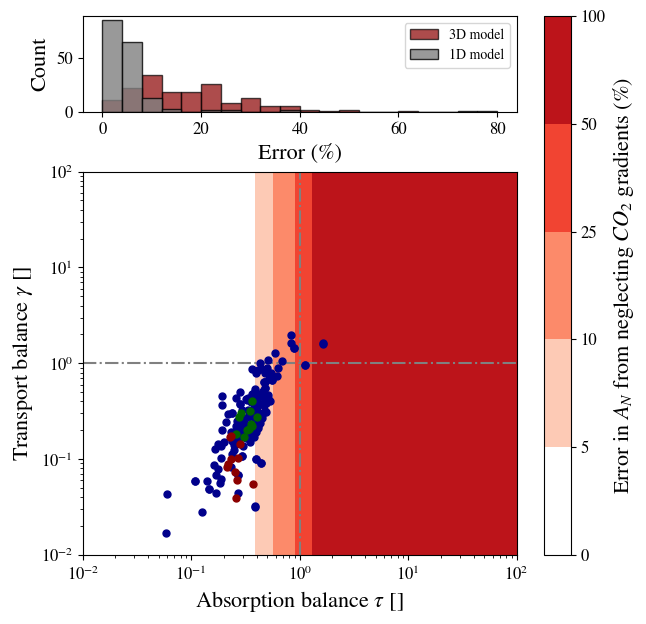

In [171]:
# load data 
df = pd.read_csv(ROOT + "data/saved_data/Knauer2022_hypostomatous.csv", decimal=',', sep=';')


# define 1D error map
N = 100
vmin, vmax = 0.01, 100
taus = np.exp(np.linspace(np.log(vmin), np.log(vmax), N))
gammas = np.exp(np.linspace(np.log(vmin), np.log(vmax), N))
err = 100*(taus/np.tanh(taus) - 1)
error1D = np.array([err for _ in gammas])

# load 3D error map
error3D = 100 * np.loadtxt(ROOT + "supplementary/files/lateral_scanning/fine_grained/typical_3Dv0D_error.txt", delimiter=";").T

# Make discrete colormap
cmap = plt.get_cmap('Reds', 6)
colors = cmap(range(5))
colors[0] = (1, 1, 1, 1)  # set the first color to white
cmap = ListedColormap(colors)
bounds = [0, 5, 10, 25, 50, 100]
norm = BoundaryNorm(bounds, cmap.N)

# create figure
fig, (ax_hist, ax_map) = plt.subplots(
    2, 1,
    gridspec_kw={"height_ratios": [1, 4], "hspace": 0.25},
    figsize=(7, 7)
 )

# map error values to data points
error1D_data = map_data_values(df, error1D)
error3D_data = map_data_values(df, error3D)

# create histogram of errors
bins = np.linspace(0, 80, 21)
ax_hist.hist(error3D_data, bins=bins, alpha=0.7, color="darkred", edgecolor="black", label="3D model")
ax_hist.hist(error1D_data, bins=bins, alpha=0.8, color="grey", edgecolor="black", label="1D model")
std_histogram(ax_hist)

# plot 1D error map and data
map = ax_map.pcolor(taus, gammas, error1D, shading="nearest", cmap=cmap, norm=norm)
fig.colorbar(map, ax=[ax_map, ax_hist], label=r'Error in $A_N$ from neglecting $CO_2$ gradients (%)', boundaries=bounds, ticks=bounds)
std_layout(ax_map)
plt.savefig(ROOT + "figures/vectorgraphics/figure3A.svg")
plt.show()


### Figure 3B

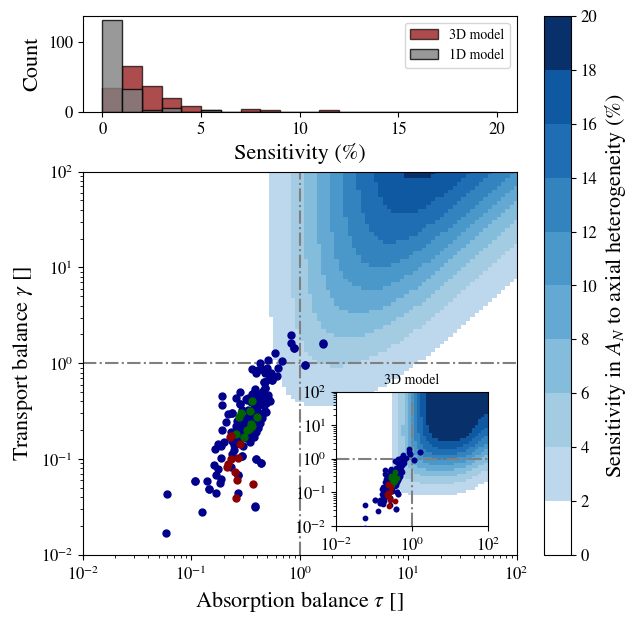

In [170]:
# load data 
df = pd.read_csv(ROOT + "data/saved_data/Knauer2022_hypostomatous.csv", decimal=',', sep=';')

# load sensitivity maps 
sensitivity1D = 100 * np.loadtxt(ROOT + "data/saved_data/sensitivities.txt", delimiter=";", skiprows=1)[::4,::4]
N = len(sensitivity1D)
vmin, vmax = 0.01, 100
taus = np.exp(np.linspace(np.log(vmin), np.log(vmax), N))
gammas = np.exp(np.linspace(np.log(vmin), np.log(vmax), N))
sensitivity3D = 100 * np.loadtxt(ROOT + "supplementary/files/lateral_scanning/rhomax_0.3_/3d_sensitivities.txt", delimiter=";").T  

# Make discrete colormap
colorN = 12
base = plt.get_cmap('Blues')

# Take only the more saturated part of the colormap, e.g. from 0.4 to 1
colors = base(np.linspace(0.2, 1, colorN - 1))  # skip very light blues
colors[0] = (1, 1, 1, 1)  # set zero bin to pure white
cmap = ListedColormap(colors)

bounds = np.linspace(0, 20, colorN - 1)
norm = BoundaryNorm(bounds, cmap.N)

# create figure
fig, (ax_hist, ax_map) = plt.subplots(
    2, 1,
    gridspec_kw={"height_ratios": [1, 4], "hspace": 0.25},
    figsize=(7, 7)
 )

# map sensitivity values to data points
sensitivity1D_data = map_data_values(df, sensitivity1D)
sensitivity3D_data = map_data_values(df, sensitivity3D)

# create histogram of errors
bins = np.linspace(0, 20, 21)
ax_hist.hist(sensitivity3D_data, bins=bins, alpha=0.7, color="darkred", edgecolor="black", label="3D model")
ax_hist.hist(sensitivity1D_data, bins=bins, alpha=0.8, color="grey", edgecolor="black", label="1D model")
std_histogram(ax_hist, xlabel="Sensitivity (%)")

# plot 1D error map and data
map = ax_map.pcolor(taus, gammas, sensitivity1D, shading="nearest", cmap=cmap, norm=norm)
fig.colorbar(map, ax=[ax_map, ax_hist], label=r'Sensitivity in $A_N$ to axial heterogeneity (%)', boundaries=bounds, ticks=bounds)
std_layout(ax_map)

# create an inset axes and plot sensitivity3D as a zoomed-in map
ax_inset = inset_axes(ax_map, width="35%", height="35%", loc='lower right', borderpad=1.3)
map_inset = ax_inset.pcolor(taus[::2], gammas[::2], sensitivity3D, shading="nearest", cmap=cmap, norm=norm)
std_layout(ax_inset, inset=True)
ax_inset.set_title("3D model", fontsize=10)

plt.savefig(ROOT + "figures/vectorgraphics/figure3B.svg")
plt.show()

### Figure 3C

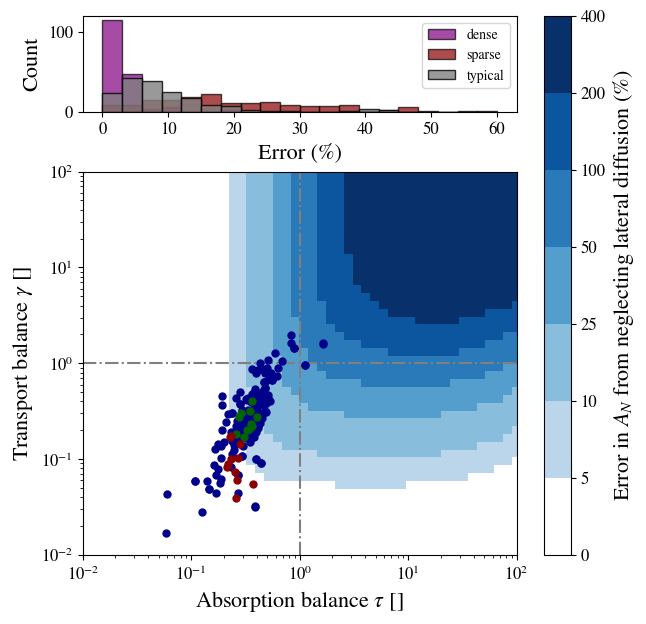

In [169]:
# load data 
df = pd.read_csv(ROOT + "data/saved_data/Knauer2022_hypostomatous.csv", decimal=',', sep=';')

# load sensitivity maps 
error_dense = 100 * np.loadtxt(ROOT + "supplementary/files/lateral_scanning/fine_grained/low_3Dv1D_error.txt", delimiter=";").T
error_sparse = 100 * np.loadtxt(ROOT + "supplementary/files/lateral_scanning/fine_grained/high_3Dv1D_error.txt", delimiter=";").T
error_typical = 100 * np.loadtxt(ROOT + "supplementary/files/lateral_scanning/fine_grained/typical_3Dv1D_error.txt", delimiter=";").T
N = len(error_typical)
vmin, vmax = 0.01, 100
taus = np.exp(np.linspace(np.log(vmin), np.log(vmax), N))
gammas = np.exp(np.linspace(np.log(vmin), np.log(vmax), N))

# Make discrete colormap
colorN = 8
base = plt.get_cmap('Blues', colorN)
colors = base(np.linspace(0.2, 1, colorN - 1))  # skip very light blues
colors[0] = (1, 1, 1, 1)  # set zero bin to pure white
cmap = ListedColormap(colors)

bounds = [0, 5, 10, 25, 50, 100, 200, 400]
norm = BoundaryNorm(bounds, cmap.N)


# create figure
fig, (ax_hist, ax_map) = plt.subplots(
    2, 1,
    gridspec_kw={"height_ratios": [1, 4], "hspace": 0.25},
    figsize=(7, 7)
 )

# map sensitivity values to data points
error_typical_data = map_data_values(df, error_typical)
error_dense_data = map_data_values(df, error_dense)
error_sparse_data = map_data_values(df, error_sparse)

# create histogram of errors
bins = np.linspace(0, 60, 21)
#ax_hist.hist(sensitivity3D_data, bins=bins, alpha=0.7, color="darkred", edgecolor="black", label="3D model")
ax_hist.hist(error_dense_data, bins=bins, alpha=0.7, color="purple", edgecolor="black", label="dense")
ax_hist.hist(error_sparse_data, bins=bins, alpha=0.7, color="darkred", edgecolor="black", label="sparse")
ax_hist.hist(error_typical_data, bins=bins, alpha=0.8, color="grey", edgecolor="black", label="typical")
std_histogram(ax_hist, xlabel="Error (%)")

# plot 1D error map and data
map = ax_map.pcolor(taus, gammas, error_typical, shading="nearest", cmap=cmap, norm=norm)
fig.colorbar(map, ax=[ax_map, ax_hist], label=r'Error in $A_N$ from neglecting lateral diffusion (%)', boundaries=bounds, ticks=bounds)
std_layout(ax_map)

plt.savefig(ROOT + "figures/vectorgraphics/figure3C.svg")
plt.show()